# DCGAN - Wasserstein GAN
https://arxiv.org/abs/1701.07875

WGAN的$D$的输出是无限制的，除非通过激活函数传递。

作者证明了存在Wasserstein的Jenson-Shannon，Kullback-Leibler，Reverse Kullback Leibler和Total Variaton距离度量的分布。

此外，Wasserstein距离在神经网络设置中保证了连续性和可微性，而F-散度的分布可能没有。 

最后，他们表明，在Kullback-Leibler，Reverse Kullback Leibler，Total Variaton和JS散度下收敛的每个分布也在Wasserstein散度下收敛，并且较小的Wasserstein散度的分布，对应于F-散度也较小。 

然而，WGAN的缺点是无法直接简单地计算Wasserstein距离。

但是，如果我们确保 $D$ 位于1-Lipschitz函数的空间内，则可以使用 $D$ 来代替Wasserstain距离。 我们通过 weight clamp 参数 $C$ 粗略地执行此操作。


# Import Necessary Packages
有一说一这个DCGAN真的太难训练了啊
我使用的Trick
- ONE-SIDE Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？
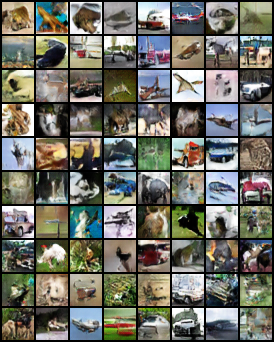


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

import numpy as np

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 100
# softlabel = 0.1 
clip = 0.01
ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel

nc = 3 # channels of output images

lr_G = 2e-4
lr_D = 2e-4 # leanring rate of Generator and Discriminator



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  2772
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator(Critic) Definitions (Wasserstein DCGAN Fashion)
 Critic (not trained to classify). 
 
- 输入一张图片
- 输出是近似真实图片与 $z\sim P(G(z))$ 的近似 Wasserstein 距离 output is the approximate Wasserstein Distance between $z\sim P(G(z))$ and real.


理论上判别器的输出是无界的，所以最后不需要Sigmoid()

It is a **unconditional** version.

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 18
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )
        
    def clip_weights(self, clip):
        for parameter in self.parameters():
            parameter.data.clamp_(-clip, clip)
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

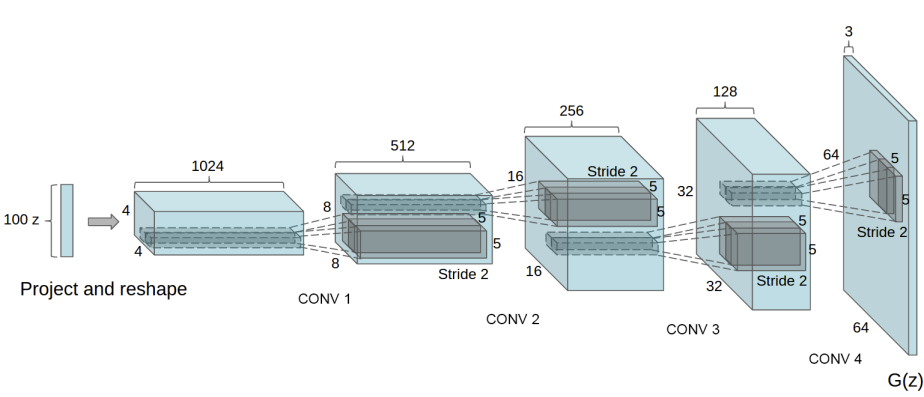

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **unconditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

WGAN并没有说明要不要初始化来着，先留着看看


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.999))

## Trainning Start!

  0%|          | 0/100 [00:00<?, ?it/s]

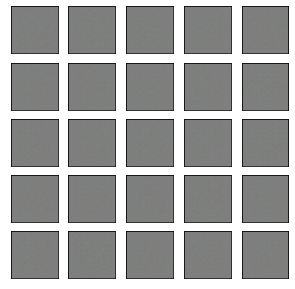

Epoch[0/100],d_loss:0.240593,g_loss:0.000319 D real: 0.022841,D fake: -0.000319
Epoch[0/100],d_loss:-0.013578,g_loss:0.007027 D real: 0.013501,D fake: -0.007027
Epoch[0/100],d_loss:-0.103258,g_loss:0.075486 D real: 0.041262,D fake: -0.075486
Epoch[0/100],d_loss:-0.284431,g_loss:0.143731 D real: 0.159840,D fake: -0.143731


  1%|          | 1/100 [00:23<38:15, 23.18s/it]

Epoch[1/100],d_loss:-0.182877,g_loss:0.160828 D real: 0.060828,D fake: -0.160828
Epoch[1/100],d_loss:-0.327100,g_loss:0.177347 D real: 0.178399,D fake: -0.177347
Epoch[1/100],d_loss:-0.292642,g_loss:0.162461 D real: 0.170346,D fake: -0.162461
Epoch[1/100],d_loss:-0.290635,g_loss:0.174238 D real: 0.169096,D fake: -0.174238


  2%|▏         | 2/100 [00:44<37:03, 22.69s/it]

Epoch[2/100],d_loss:-0.220328,g_loss:0.133932 D real: 0.100858,D fake: -0.133932
Epoch[2/100],d_loss:-0.110402,g_loss:0.109914 D real: 0.052989,D fake: -0.109914
Epoch[2/100],d_loss:-0.030500,g_loss:0.061810 D real: 0.068985,D fake: -0.061810
Epoch[2/100],d_loss:-0.142672,g_loss:0.081972 D real: 0.127510,D fake: -0.081972


  3%|▎         | 3/100 [01:04<35:30, 21.96s/it]

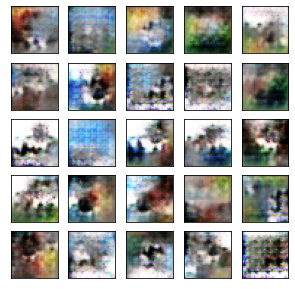

Epoch[3/100],d_loss:-0.113051,g_loss:0.096672 D real: 0.056379,D fake: -0.096672
Epoch[3/100],d_loss:-0.187300,g_loss:0.109336 D real: 0.088217,D fake: -0.109336
Epoch[3/100],d_loss:-0.120884,g_loss:0.121989 D real: 0.063417,D fake: -0.121989
Epoch[3/100],d_loss:-0.128395,g_loss:0.094318 D real: 0.069905,D fake: -0.094318


  4%|▍         | 4/100 [01:29<36:20, 22.71s/it]

Epoch[4/100],d_loss:-0.163205,g_loss:0.086003 D real: 0.081616,D fake: -0.086003
Epoch[4/100],d_loss:-0.170063,g_loss:0.102638 D real: 0.083488,D fake: -0.102638
Epoch[4/100],d_loss:-0.117184,g_loss:0.094374 D real: 0.085691,D fake: -0.094374
Epoch[4/100],d_loss:-0.151814,g_loss:0.100184 D real: 0.099621,D fake: -0.100184


  5%|▌         | 5/100 [01:48<34:00, 21.48s/it]

Epoch[5/100],d_loss:-0.113243,g_loss:0.066795 D real: 0.066050,D fake: -0.066795
Epoch[5/100],d_loss:-0.128972,g_loss:0.087192 D real: 0.099395,D fake: -0.087192
Epoch[5/100],d_loss:-0.156276,g_loss:0.117873 D real: 0.105669,D fake: -0.117873
Epoch[5/100],d_loss:-0.130641,g_loss:0.082928 D real: 0.085538,D fake: -0.082928


  6%|▌         | 6/100 [02:05<31:43, 20.25s/it]

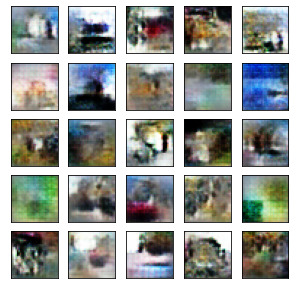

Epoch[6/100],d_loss:-0.119185,g_loss:0.077223 D real: 0.088638,D fake: -0.077223
Epoch[6/100],d_loss:-0.149075,g_loss:0.100935 D real: 0.097700,D fake: -0.100935
Epoch[6/100],d_loss:-0.153703,g_loss:0.090101 D real: 0.094543,D fake: -0.090101
Epoch[6/100],d_loss:-0.105509,g_loss:0.063365 D real: 0.078944,D fake: -0.063365


  7%|▋         | 7/100 [02:25<31:25, 20.28s/it]

Epoch[7/100],d_loss:-0.111455,g_loss:0.037766 D real: 0.059792,D fake: -0.037766
Epoch[7/100],d_loss:-0.118159,g_loss:0.067637 D real: 0.060229,D fake: -0.067637
Epoch[7/100],d_loss:-0.096718,g_loss:0.079432 D real: 0.047403,D fake: -0.079432
Epoch[7/100],d_loss:-0.088048,g_loss:0.066238 D real: 0.061715,D fake: -0.066238


  8%|▊         | 8/100 [02:46<31:24, 20.49s/it]

Epoch[8/100],d_loss:-0.111506,g_loss:0.091292 D real: 0.073702,D fake: -0.091292
Epoch[8/100],d_loss:-0.104304,g_loss:0.064428 D real: 0.055462,D fake: -0.064428
Epoch[8/100],d_loss:-0.108170,g_loss:0.056019 D real: 0.078574,D fake: -0.056019
Epoch[8/100],d_loss:-0.075361,g_loss:0.062861 D real: 0.072140,D fake: -0.062861


  9%|▉         | 9/100 [03:10<32:41, 21.55s/it]

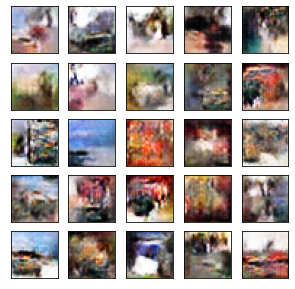

Epoch[9/100],d_loss:-0.074528,g_loss:0.051564 D real: 0.050097,D fake: -0.051564
Epoch[9/100],d_loss:-0.129689,g_loss:0.090326 D real: 0.073943,D fake: -0.090326
Epoch[9/100],d_loss:-0.107410,g_loss:0.069761 D real: 0.056954,D fake: -0.069761
Epoch[9/100],d_loss:-0.113942,g_loss:0.070090 D real: 0.094918,D fake: -0.070090


 10%|█         | 10/100 [03:31<31:44, 21.16s/it]

Epoch[10/100],d_loss:-0.086661,g_loss:0.076994 D real: 0.053177,D fake: -0.076994
Epoch[10/100],d_loss:-0.094257,g_loss:0.081371 D real: 0.064075,D fake: -0.081371
Epoch[10/100],d_loss:-0.072795,g_loss:0.085952 D real: 0.021720,D fake: -0.085952
Epoch[10/100],d_loss:-0.101337,g_loss:0.087773 D real: 0.087563,D fake: -0.087773


 11%|█         | 11/100 [03:49<30:03, 20.26s/it]

Epoch[11/100],d_loss:-0.078468,g_loss:0.065587 D real: 0.045603,D fake: -0.065587
Epoch[11/100],d_loss:-0.087326,g_loss:0.023077 D real: 0.096569,D fake: -0.023077
Epoch[11/100],d_loss:-0.075299,g_loss:0.033328 D real: 0.034099,D fake: -0.033328
Epoch[11/100],d_loss:-0.097367,g_loss:0.072463 D real: 0.059336,D fake: -0.072463


 12%|█▏        | 12/100 [04:10<29:59, 20.44s/it]

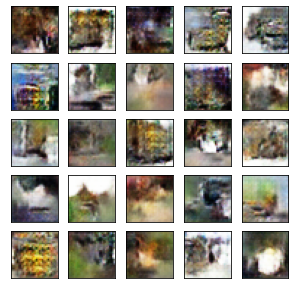

Epoch[12/100],d_loss:-0.051211,g_loss:0.027881 D real: 0.051343,D fake: -0.027881
Epoch[12/100],d_loss:-0.067880,g_loss:0.064349 D real: 0.011746,D fake: -0.064349
Epoch[12/100],d_loss:-0.060164,g_loss:0.066374 D real: 0.056183,D fake: -0.066374
Epoch[12/100],d_loss:-0.073966,g_loss:0.080331 D real: 0.054771,D fake: -0.080331


 13%|█▎        | 13/100 [04:34<31:11, 21.51s/it]

Epoch[13/100],d_loss:-0.046152,g_loss:0.022435 D real: 0.035525,D fake: -0.022435
Epoch[13/100],d_loss:-0.093226,g_loss:0.067569 D real: 0.068228,D fake: -0.067569
Epoch[13/100],d_loss:-0.095012,g_loss:0.073983 D real: 0.040322,D fake: -0.073983
Epoch[13/100],d_loss:-0.072467,g_loss:0.022870 D real: 0.046223,D fake: -0.022870


 14%|█▍        | 14/100 [04:55<30:44, 21.44s/it]

Epoch[14/100],d_loss:-0.059922,g_loss:0.032429 D real: 0.011850,D fake: -0.032429
Epoch[14/100],d_loss:-0.094767,g_loss:0.046422 D real: 0.074420,D fake: -0.046422
Epoch[14/100],d_loss:-0.060282,g_loss:0.014842 D real: 0.037257,D fake: -0.014842
Epoch[14/100],d_loss:-0.074349,g_loss:0.056640 D real: 0.039986,D fake: -0.056640


 15%|█▌        | 15/100 [05:16<30:20, 21.42s/it]

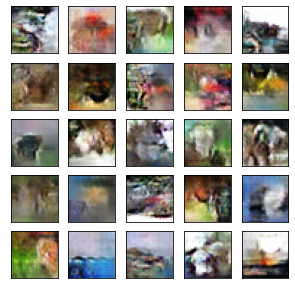

Epoch[15/100],d_loss:-0.078408,g_loss:0.062826 D real: 0.031773,D fake: -0.062826
Epoch[15/100],d_loss:-0.064981,g_loss:0.078744 D real: 0.008591,D fake: -0.078744
Epoch[15/100],d_loss:-0.082507,g_loss:0.040708 D real: 0.054453,D fake: -0.040708
Epoch[15/100],d_loss:-0.020162,g_loss:0.008693 D real: 0.040786,D fake: -0.008693


 16%|█▌        | 16/100 [05:39<30:22, 21.70s/it]

Epoch[16/100],d_loss:-0.054089,g_loss:0.085761 D real: 0.055426,D fake: -0.085761
Epoch[16/100],d_loss:-0.089902,g_loss:0.030455 D real: 0.037033,D fake: -0.030455
Epoch[16/100],d_loss:-0.063846,g_loss:0.027343 D real: 0.049529,D fake: -0.027343
Epoch[16/100],d_loss:-0.049462,g_loss:0.064899 D real: 0.035222,D fake: -0.064899


 17%|█▋        | 17/100 [05:56<28:24, 20.54s/it]

Epoch[17/100],d_loss:-0.074470,g_loss:0.063162 D real: 0.030538,D fake: -0.063162
Epoch[17/100],d_loss:-0.048105,g_loss:0.014620 D real: 0.000102,D fake: -0.014620
Epoch[17/100],d_loss:-0.048186,g_loss:-0.007059 D real: 0.060302,D fake: 0.007059
Epoch[17/100],d_loss:-0.026602,g_loss:0.038999 D real: 0.034197,D fake: -0.038999


 18%|█▊        | 18/100 [06:18<28:40, 20.99s/it]

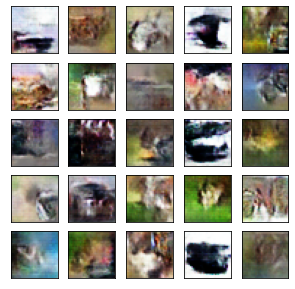

Epoch[18/100],d_loss:-0.058067,g_loss:0.016243 D real: 0.031653,D fake: -0.016243
Epoch[18/100],d_loss:-0.010038,g_loss:0.047581 D real: 0.008082,D fake: -0.047581
Epoch[18/100],d_loss:-0.060996,g_loss:0.054396 D real: 0.043737,D fake: -0.054396
Epoch[18/100],d_loss:-0.039420,g_loss:0.020222 D real: 0.040813,D fake: -0.020222


 19%|█▉        | 19/100 [06:44<30:10, 22.35s/it]

Epoch[19/100],d_loss:-0.041369,g_loss:0.054458 D real: 0.009225,D fake: -0.054458
Epoch[19/100],d_loss:-0.056036,g_loss:0.018841 D real: 0.090316,D fake: -0.018841
Epoch[19/100],d_loss:-0.026579,g_loss:0.043007 D real: 0.048144,D fake: -0.043007
Epoch[19/100],d_loss:-0.024262,g_loss:0.033649 D real: 0.046172,D fake: -0.033649


 20%|██        | 20/100 [07:06<29:30, 22.13s/it]

Epoch[20/100],d_loss:-0.017935,g_loss:0.037179 D real: -0.016773,D fake: -0.037179
Epoch[20/100],d_loss:0.010798,g_loss:-0.044073 D real: 0.033309,D fake: 0.044073
Epoch[20/100],d_loss:-0.044384,g_loss:-0.027854 D real: 0.051845,D fake: 0.027854
Epoch[20/100],d_loss:-0.027303,g_loss:-0.043918 D real: 0.087576,D fake: 0.043918


 21%|██        | 21/100 [07:23<27:25, 20.83s/it]

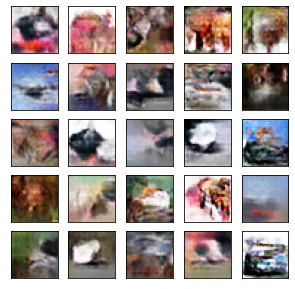

Epoch[21/100],d_loss:0.005925,g_loss:0.034783 D real: -0.030315,D fake: -0.034783
Epoch[21/100],d_loss:-0.008178,g_loss:-0.028754 D real: 0.034624,D fake: 0.028754
Epoch[21/100],d_loss:0.016762,g_loss:0.035322 D real: -0.031133,D fake: -0.035322
Epoch[21/100],d_loss:-0.030361,g_loss:0.004465 D real: 0.022477,D fake: -0.004465


 22%|██▏       | 22/100 [07:41<25:49, 19.87s/it]

Epoch[22/100],d_loss:0.016966,g_loss:-0.063517 D real: 0.040505,D fake: 0.063517
Epoch[22/100],d_loss:0.003167,g_loss:-0.064274 D real: 0.059814,D fake: 0.064274
Epoch[22/100],d_loss:0.010314,g_loss:-0.046304 D real: 0.058594,D fake: 0.046304
Epoch[22/100],d_loss:0.003550,g_loss:0.089232 D real: -0.090907,D fake: -0.089232


 23%|██▎       | 23/100 [08:00<25:12, 19.64s/it]

Epoch[23/100],d_loss:-0.018632,g_loss:0.024895 D real: 0.003229,D fake: -0.024895
Epoch[23/100],d_loss:0.003314,g_loss:0.064770 D real: -0.059021,D fake: -0.064770
Epoch[23/100],d_loss:-0.009235,g_loss:0.002602 D real: 0.011904,D fake: -0.002602
Epoch[23/100],d_loss:0.000353,g_loss:-0.003197 D real: 0.007419,D fake: 0.003197


 24%|██▍       | 24/100 [08:23<26:08, 20.64s/it]

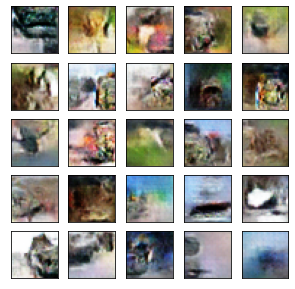

Epoch[24/100],d_loss:0.001255,g_loss:-0.007632 D real: 0.007733,D fake: 0.007632
Epoch[24/100],d_loss:-0.010410,g_loss:0.008208 D real: -0.002361,D fake: -0.008208
Epoch[24/100],d_loss:-0.001420,g_loss:0.015238 D real: -0.006728,D fake: -0.015238
Epoch[24/100],d_loss:-0.013109,g_loss:0.000934 D real: 0.012319,D fake: -0.000934


 25%|██▌       | 25/100 [08:48<27:13, 21.78s/it]

Epoch[25/100],d_loss:-0.008852,g_loss:0.015646 D real: -0.003034,D fake: -0.015646
Epoch[25/100],d_loss:-0.008353,g_loss:0.009337 D real: -0.000769,D fake: -0.009337
Epoch[25/100],d_loss:-0.008394,g_loss:-0.012968 D real: 0.016745,D fake: 0.012968
Epoch[25/100],d_loss:-0.000492,g_loss:0.001752 D real: 0.002307,D fake: -0.001752


 26%|██▌       | 26/100 [09:12<27:48, 22.55s/it]

Epoch[26/100],d_loss:-0.002125,g_loss:-0.051294 D real: 0.043266,D fake: 0.051294
Epoch[26/100],d_loss:-0.009669,g_loss:0.000171 D real: 0.010322,D fake: -0.000171
Epoch[26/100],d_loss:0.015455,g_loss:-0.008058 D real: -0.000504,D fake: 0.008058
Epoch[26/100],d_loss:0.003385,g_loss:-0.001244 D real: 0.003847,D fake: 0.001244


 27%|██▋       | 27/100 [09:31<26:04, 21.43s/it]

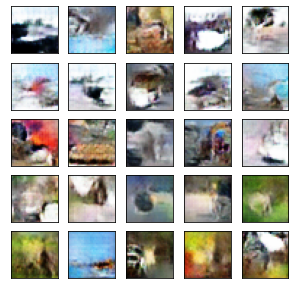

Epoch[27/100],d_loss:-0.011296,g_loss:-0.000059 D real: 0.009053,D fake: 0.000059
Epoch[27/100],d_loss:0.001711,g_loss:-0.003434 D real: 0.015914,D fake: 0.003434
Epoch[27/100],d_loss:-0.002053,g_loss:0.016894 D real: -0.015135,D fake: -0.016894
Epoch[27/100],d_loss:0.007695,g_loss:-0.000834 D real: -0.002894,D fake: 0.000834


 28%|██▊       | 28/100 [09:55<26:38, 22.20s/it]

Epoch[28/100],d_loss:-0.001724,g_loss:0.008911 D real: -0.010035,D fake: -0.008911
Epoch[28/100],d_loss:0.001779,g_loss:-0.006045 D real: 0.003031,D fake: 0.006045
Epoch[28/100],d_loss:0.001877,g_loss:-0.014317 D real: 0.013373,D fake: 0.014317
Epoch[28/100],d_loss:-0.007484,g_loss:0.007775 D real: -0.001336,D fake: -0.007775


 29%|██▉       | 29/100 [10:13<24:59, 21.12s/it]

Epoch[29/100],d_loss:-0.002658,g_loss:0.013315 D real: -0.008621,D fake: -0.013315
Epoch[29/100],d_loss:0.000845,g_loss:0.008529 D real: -0.008851,D fake: -0.008529
Epoch[29/100],d_loss:0.003088,g_loss:0.009038 D real: -0.006337,D fake: -0.009038
Epoch[29/100],d_loss:-0.002342,g_loss:0.010360 D real: -0.008725,D fake: -0.010360


 30%|███       | 30/100 [10:35<24:53, 21.33s/it]

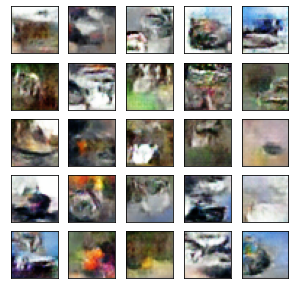

Epoch[30/100],d_loss:-0.002909,g_loss:0.024596 D real: -0.023243,D fake: -0.024596
Epoch[30/100],d_loss:-0.003375,g_loss:0.013407 D real: -0.011234,D fake: -0.013407
Epoch[30/100],d_loss:-0.001944,g_loss:0.006946 D real: -0.000644,D fake: -0.006946
Epoch[30/100],d_loss:-0.004602,g_loss:-0.003287 D real: 0.005196,D fake: 0.003287


 31%|███       | 31/100 [10:53<23:20, 20.29s/it]

Epoch[31/100],d_loss:-0.006624,g_loss:-0.002421 D real: 0.007541,D fake: 0.002421
Epoch[31/100],d_loss:-0.016085,g_loss:0.026409 D real: -0.005987,D fake: -0.026409
Epoch[31/100],d_loss:-0.000920,g_loss:0.013852 D real: -0.016053,D fake: -0.013852
Epoch[31/100],d_loss:-0.008000,g_loss:0.027057 D real: -0.017785,D fake: -0.027057


 32%|███▏      | 32/100 [11:13<22:53, 20.19s/it]

Epoch[32/100],d_loss:-0.010732,g_loss:0.026183 D real: -0.021628,D fake: -0.026183
Epoch[32/100],d_loss:-0.003109,g_loss:-0.020159 D real: 0.021186,D fake: 0.020159
Epoch[32/100],d_loss:0.001983,g_loss:-0.016059 D real: 0.014582,D fake: 0.016059
Epoch[32/100],d_loss:0.003450,g_loss:-0.000040 D real: 0.001462,D fake: 0.000040


 33%|███▎      | 33/100 [11:30<21:34, 19.33s/it]

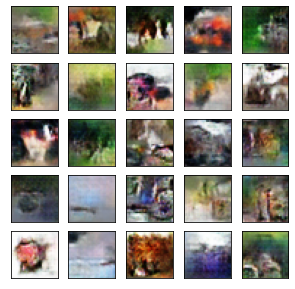

Epoch[33/100],d_loss:0.000182,g_loss:0.012028 D real: -0.010623,D fake: -0.012028
Epoch[33/100],d_loss:-0.000561,g_loss:0.005878 D real: 0.000457,D fake: -0.005878
Epoch[33/100],d_loss:-0.006002,g_loss:0.003533 D real: 0.001874,D fake: -0.003533
Epoch[33/100],d_loss:-0.001859,g_loss:0.009216 D real: -0.001790,D fake: -0.009216


 34%|███▍      | 34/100 [11:52<22:13, 20.20s/it]

Epoch[34/100],d_loss:-0.007230,g_loss:0.032344 D real: -0.031101,D fake: -0.032344
Epoch[34/100],d_loss:0.006148,g_loss:-0.040453 D real: 0.024231,D fake: 0.040453
Epoch[34/100],d_loss:0.003895,g_loss:0.019907 D real: -0.017832,D fake: -0.019907
Epoch[34/100],d_loss:-0.007594,g_loss:-0.004495 D real: 0.011314,D fake: 0.004495


 35%|███▌      | 35/100 [12:17<23:11, 21.42s/it]

Epoch[35/100],d_loss:0.014987,g_loss:-0.017481 D real: 0.009417,D fake: 0.017481
Epoch[35/100],d_loss:0.006219,g_loss:0.016337 D real: -0.008565,D fake: -0.016337
Epoch[35/100],d_loss:-0.006200,g_loss:0.006245 D real: -0.001634,D fake: -0.006245
Epoch[35/100],d_loss:0.002738,g_loss:0.002179 D real: 0.008232,D fake: -0.002179


 36%|███▌      | 36/100 [12:35<21:44, 20.39s/it]

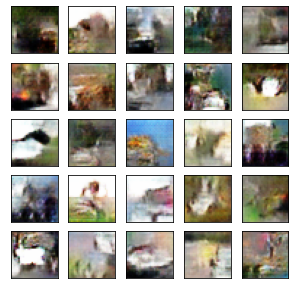

Epoch[36/100],d_loss:0.005269,g_loss:0.015122 D real: -0.009135,D fake: -0.015122
Epoch[36/100],d_loss:-0.007406,g_loss:0.035540 D real: -0.041121,D fake: -0.035540
Epoch[36/100],d_loss:0.001188,g_loss:0.080250 D real: -0.085581,D fake: -0.080250
Epoch[36/100],d_loss:-0.026203,g_loss:0.013180 D real: 0.014549,D fake: -0.013180


 37%|███▋      | 37/100 [12:56<21:45, 20.72s/it]

Epoch[37/100],d_loss:-0.000669,g_loss:0.005632 D real: -0.003518,D fake: -0.005632
Epoch[37/100],d_loss:-0.002022,g_loss:0.017907 D real: -0.016970,D fake: -0.017907
Epoch[37/100],d_loss:-0.012766,g_loss:-0.000130 D real: 0.016731,D fake: 0.000130
Epoch[37/100],d_loss:0.006775,g_loss:0.049914 D real: -0.043125,D fake: -0.049914


 38%|███▊      | 38/100 [13:17<21:18, 20.62s/it]

Epoch[38/100],d_loss:-0.019646,g_loss:0.015689 D real: 0.028129,D fake: -0.015689
Epoch[38/100],d_loss:-0.010456,g_loss:0.075016 D real: -0.066132,D fake: -0.075016
Epoch[38/100],d_loss:-0.001219,g_loss:-0.033844 D real: 0.042031,D fake: 0.033844
Epoch[38/100],d_loss:-0.005326,g_loss:0.043787 D real: -0.051325,D fake: -0.043787


 39%|███▉      | 39/100 [13:37<20:55, 20.58s/it]

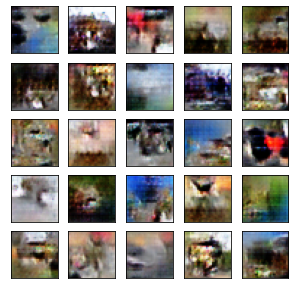

Epoch[39/100],d_loss:-0.002527,g_loss:0.125294 D real: -0.121353,D fake: -0.125294
Epoch[39/100],d_loss:-0.011507,g_loss:-0.021683 D real: 0.045283,D fake: 0.021683
Epoch[39/100],d_loss:-0.006038,g_loss:-0.011337 D real: 0.011902,D fake: 0.011337
Epoch[39/100],d_loss:-0.004892,g_loss:-0.017097 D real: 0.018367,D fake: 0.017097


 40%|████      | 40/100 [14:00<21:10, 21.18s/it]

Epoch[40/100],d_loss:0.004996,g_loss:0.049610 D real: -0.061935,D fake: -0.049610
Epoch[40/100],d_loss:-0.012652,g_loss:0.000559 D real: 0.024384,D fake: -0.000559
Epoch[40/100],d_loss:-0.001244,g_loss:-0.049245 D real: 0.054668,D fake: 0.049245
Epoch[40/100],d_loss:0.002412,g_loss:-0.037900 D real: 0.041632,D fake: 0.037900


 41%|████      | 41/100 [14:21<20:58, 21.33s/it]

Epoch[41/100],d_loss:-0.016532,g_loss:0.026018 D real: -0.028947,D fake: -0.026018
Epoch[41/100],d_loss:-0.004440,g_loss:0.007284 D real: -0.001978,D fake: -0.007284
Epoch[41/100],d_loss:0.007601,g_loss:-0.036860 D real: 0.025214,D fake: 0.036860
Epoch[41/100],d_loss:-0.001625,g_loss:-0.031001 D real: 0.031250,D fake: 0.031001


 42%|████▏     | 42/100 [14:41<20:09, 20.85s/it]

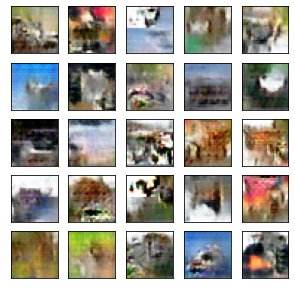

Epoch[42/100],d_loss:-0.002485,g_loss:-0.063731 D real: 0.073542,D fake: 0.063731
Epoch[42/100],d_loss:0.008360,g_loss:-0.094924 D real: 0.084769,D fake: 0.094924
Epoch[42/100],d_loss:0.007751,g_loss:-0.018026 D real: 0.006875,D fake: 0.018026
Epoch[42/100],d_loss:-0.008736,g_loss:-0.030593 D real: 0.032419,D fake: 0.030593


 43%|████▎     | 43/100 [15:07<21:10, 22.28s/it]

Epoch[43/100],d_loss:0.003676,g_loss:-0.014694 D real: 0.010895,D fake: 0.014694
Epoch[43/100],d_loss:0.008590,g_loss:0.075606 D real: -0.063939,D fake: -0.075606
Epoch[43/100],d_loss:0.006277,g_loss:0.017890 D real: -0.006861,D fake: -0.017890
Epoch[43/100],d_loss:-0.010673,g_loss:0.041728 D real: -0.028851,D fake: -0.041728


 44%|████▍     | 44/100 [15:24<19:28, 20.86s/it]

Epoch[44/100],d_loss:-0.008024,g_loss:-0.050715 D real: 0.070529,D fake: 0.050715
Epoch[44/100],d_loss:-0.017943,g_loss:-0.001214 D real: 0.006497,D fake: 0.001214
Epoch[44/100],d_loss:-0.002658,g_loss:-0.063008 D real: 0.068969,D fake: 0.063008
Epoch[44/100],d_loss:-0.010487,g_loss:0.039083 D real: -0.024852,D fake: -0.039083


 45%|████▌     | 45/100 [15:43<18:38, 20.33s/it]

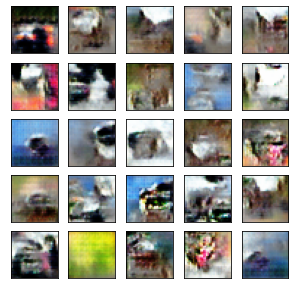

Epoch[45/100],d_loss:-0.003034,g_loss:-0.010842 D real: 0.017120,D fake: 0.010842
Epoch[45/100],d_loss:-0.015305,g_loss:-0.065470 D real: 0.066379,D fake: 0.065470
Epoch[45/100],d_loss:0.011155,g_loss:-0.032766 D real: 0.012175,D fake: 0.032766
Epoch[45/100],d_loss:-0.014283,g_loss:-0.006313 D real: 0.018846,D fake: 0.006313


 46%|████▌     | 46/100 [16:05<18:41, 20.76s/it]

Epoch[46/100],d_loss:-0.026018,g_loss:-0.006286 D real: 0.034503,D fake: 0.006286
Epoch[46/100],d_loss:-0.009884,g_loss:0.005971 D real: 0.002621,D fake: -0.005971
Epoch[46/100],d_loss:0.001753,g_loss:0.016849 D real: -0.018287,D fake: -0.016849
Epoch[46/100],d_loss:-0.000244,g_loss:-0.025906 D real: 0.031689,D fake: 0.025906


 47%|████▋     | 47/100 [16:27<18:39, 21.12s/it]

Epoch[47/100],d_loss:-0.002581,g_loss:0.013084 D real: -0.003494,D fake: -0.013084
Epoch[47/100],d_loss:0.015115,g_loss:-0.052955 D real: 0.040785,D fake: 0.052955
Epoch[47/100],d_loss:-0.017416,g_loss:-0.005794 D real: 0.013580,D fake: 0.005794
Epoch[47/100],d_loss:0.012400,g_loss:-0.063701 D real: 0.058689,D fake: 0.063701


 48%|████▊     | 48/100 [16:47<18:07, 20.91s/it]

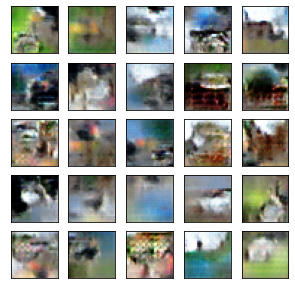

Epoch[48/100],d_loss:-0.019328,g_loss:0.062286 D real: -0.058467,D fake: -0.062286
Epoch[48/100],d_loss:-0.007440,g_loss:0.012252 D real: 0.004448,D fake: -0.012252
Epoch[48/100],d_loss:-0.001148,g_loss:0.015153 D real: -0.003134,D fake: -0.015153
Epoch[48/100],d_loss:-0.018141,g_loss:0.001494 D real: 0.023381,D fake: -0.001494


 49%|████▉     | 49/100 [17:11<18:19, 21.55s/it]

Epoch[49/100],d_loss:0.000820,g_loss:-0.065602 D real: 0.073751,D fake: 0.065602
Epoch[49/100],d_loss:0.013352,g_loss:0.023770 D real: -0.017492,D fake: -0.023770
Epoch[49/100],d_loss:0.021513,g_loss:-0.063884 D real: 0.050669,D fake: 0.063884
Epoch[49/100],d_loss:0.012916,g_loss:-0.084874 D real: 0.055373,D fake: 0.084874


 50%|█████     | 50/100 [17:30<17:21, 20.84s/it]

Epoch[50/100],d_loss:-0.011023,g_loss:-0.055792 D real: 0.080713,D fake: 0.055792
Epoch[50/100],d_loss:-0.003801,g_loss:-0.003977 D real: 0.029234,D fake: 0.003977
Epoch[50/100],d_loss:-0.005265,g_loss:0.020676 D real: -0.016449,D fake: -0.020676
Epoch[50/100],d_loss:0.012299,g_loss:-0.007301 D real: 0.012474,D fake: 0.007301


 51%|█████     | 51/100 [17:52<17:24, 21.32s/it]

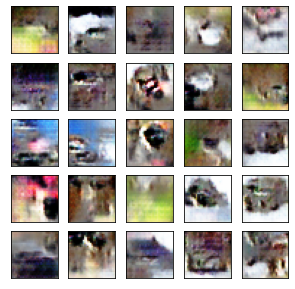

Epoch[51/100],d_loss:0.010542,g_loss:0.019285 D real: -0.034682,D fake: -0.019285
Epoch[51/100],d_loss:-0.003397,g_loss:0.021737 D real: -0.009598,D fake: -0.021737
Epoch[51/100],d_loss:-0.029355,g_loss:0.005436 D real: 0.010811,D fake: -0.005436
Epoch[51/100],d_loss:0.011087,g_loss:-0.046158 D real: 0.034012,D fake: 0.046158


 52%|█████▏    | 52/100 [18:14<17:11, 21.49s/it]

Epoch[52/100],d_loss:-0.008814,g_loss:0.036804 D real: -0.023476,D fake: -0.036804
Epoch[52/100],d_loss:-0.010903,g_loss:0.003906 D real: -0.010553,D fake: -0.003906
Epoch[52/100],d_loss:0.003342,g_loss:0.010541 D real: -0.001159,D fake: -0.010541
Epoch[52/100],d_loss:-0.027374,g_loss:0.076590 D real: -0.065316,D fake: -0.076590


 53%|█████▎    | 53/100 [18:33<16:11, 20.67s/it]

Epoch[53/100],d_loss:0.018241,g_loss:-0.040104 D real: 0.023549,D fake: 0.040104
Epoch[53/100],d_loss:0.000904,g_loss:-0.040835 D real: 0.025132,D fake: 0.040835
Epoch[53/100],d_loss:-0.008339,g_loss:0.013547 D real: -0.014234,D fake: -0.013547
Epoch[53/100],d_loss:-0.013415,g_loss:0.003126 D real: -0.001876,D fake: -0.003126


 54%|█████▍    | 54/100 [18:53<15:48, 20.63s/it]

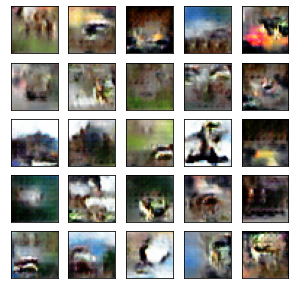

Epoch[54/100],d_loss:0.002663,g_loss:0.009031 D real: -0.011389,D fake: -0.009031
Epoch[54/100],d_loss:0.008583,g_loss:-0.022153 D real: 0.011005,D fake: 0.022153
Epoch[54/100],d_loss:-0.007176,g_loss:0.007126 D real: -0.001867,D fake: -0.007126
Epoch[54/100],d_loss:-0.011630,g_loss:0.020899 D real: -0.009830,D fake: -0.020899


 55%|█████▌    | 55/100 [19:14<15:23, 20.51s/it]

Epoch[55/100],d_loss:-0.005931,g_loss:0.057882 D real: -0.054149,D fake: -0.057882
Epoch[55/100],d_loss:0.012328,g_loss:-0.053329 D real: 0.040185,D fake: 0.053329
Epoch[55/100],d_loss:-0.015300,g_loss:0.039425 D real: -0.028436,D fake: -0.039425
Epoch[55/100],d_loss:0.001971,g_loss:0.066307 D real: -0.054503,D fake: -0.066307


 56%|█████▌    | 56/100 [19:35<15:15, 20.80s/it]

Epoch[56/100],d_loss:0.006370,g_loss:-0.014575 D real: -0.004127,D fake: 0.014575
Epoch[56/100],d_loss:0.000277,g_loss:0.025478 D real: -0.022423,D fake: -0.025478
Epoch[56/100],d_loss:-0.001031,g_loss:-0.043278 D real: 0.057340,D fake: 0.043278
Epoch[56/100],d_loss:-0.007226,g_loss:-0.016013 D real: 0.024712,D fake: 0.016013


 57%|█████▋    | 57/100 [19:53<14:21, 20.04s/it]

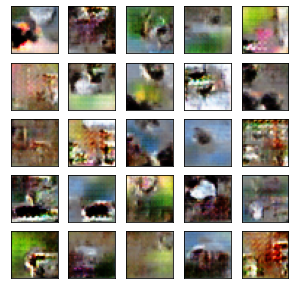

Epoch[57/100],d_loss:0.001864,g_loss:0.052186 D real: -0.053151,D fake: -0.052186
Epoch[57/100],d_loss:-0.005619,g_loss:0.052426 D real: -0.048975,D fake: -0.052426
Epoch[57/100],d_loss:-0.002410,g_loss:-0.099544 D real: 0.102987,D fake: 0.099544
Epoch[57/100],d_loss:0.027588,g_loss:-0.042380 D real: 0.019862,D fake: 0.042380


 58%|█████▊    | 58/100 [20:18<15:04, 21.53s/it]

Epoch[58/100],d_loss:-0.005617,g_loss:-0.024320 D real: 0.022798,D fake: 0.024320
Epoch[58/100],d_loss:-0.005071,g_loss:0.069672 D real: -0.052447,D fake: -0.069672
Epoch[58/100],d_loss:-0.010791,g_loss:0.109453 D real: -0.096062,D fake: -0.109453
Epoch[58/100],d_loss:-0.019540,g_loss:0.012151 D real: 0.007215,D fake: -0.012151


 59%|█████▉    | 59/100 [20:38<14:25, 21.11s/it]

Epoch[59/100],d_loss:0.001413,g_loss:-0.027340 D real: 0.028886,D fake: 0.027340
Epoch[59/100],d_loss:-0.037147,g_loss:0.076833 D real: -0.030378,D fake: -0.076833
Epoch[59/100],d_loss:-0.030079,g_loss:0.054756 D real: -0.042067,D fake: -0.054756
Epoch[59/100],d_loss:-0.025051,g_loss:0.033289 D real: 0.010207,D fake: -0.033289


 60%|██████    | 60/100 [21:00<14:05, 21.14s/it]

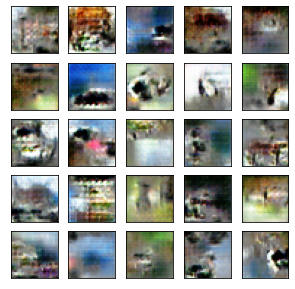

Epoch[60/100],d_loss:-0.009174,g_loss:0.125792 D real: -0.105327,D fake: -0.125792
Epoch[60/100],d_loss:-0.019211,g_loss:-0.010958 D real: 0.021735,D fake: 0.010958
Epoch[60/100],d_loss:-0.021277,g_loss:-0.073358 D real: 0.092267,D fake: 0.073358
Epoch[60/100],d_loss:0.013098,g_loss:-0.019717 D real: 0.021392,D fake: 0.019717


 61%|██████    | 61/100 [21:21<13:49, 21.26s/it]

Epoch[61/100],d_loss:-0.000890,g_loss:0.027012 D real: -0.010542,D fake: -0.027012
Epoch[61/100],d_loss:0.023706,g_loss:-0.004698 D real: -0.014788,D fake: 0.004698
Epoch[61/100],d_loss:-0.002853,g_loss:0.004145 D real: -0.000776,D fake: -0.004145
Epoch[61/100],d_loss:-0.006102,g_loss:-0.073910 D real: 0.128509,D fake: 0.073910


 62%|██████▏   | 62/100 [21:42<13:24, 21.16s/it]

Epoch[62/100],d_loss:-0.002970,g_loss:-0.004968 D real: -0.009612,D fake: 0.004968
Epoch[62/100],d_loss:-0.008463,g_loss:-0.100170 D real: 0.117354,D fake: 0.100170
Epoch[62/100],d_loss:-0.010227,g_loss:-0.058987 D real: 0.063346,D fake: 0.058987
Epoch[62/100],d_loss:0.008833,g_loss:0.002868 D real: -0.011181,D fake: -0.002868


 63%|██████▎   | 63/100 [22:04<13:05, 21.23s/it]

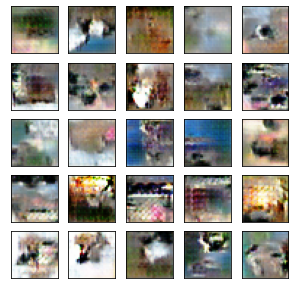

Epoch[63/100],d_loss:-0.019036,g_loss:-0.003451 D real: 0.047062,D fake: 0.003451
Epoch[63/100],d_loss:-0.005643,g_loss:-0.005162 D real: 0.038891,D fake: 0.005162
Epoch[63/100],d_loss:0.008533,g_loss:0.018135 D real: -0.018918,D fake: -0.018135
Epoch[63/100],d_loss:0.013500,g_loss:0.020274 D real: -0.046716,D fake: -0.020274


 64%|██████▍   | 64/100 [22:27<13:09, 21.92s/it]

Epoch[64/100],d_loss:-0.007324,g_loss:-0.000820 D real: 0.023390,D fake: 0.000820
Epoch[64/100],d_loss:-0.006773,g_loss:-0.047441 D real: 0.028228,D fake: 0.047441
Epoch[64/100],d_loss:-0.004885,g_loss:0.112194 D real: -0.100103,D fake: -0.112194
Epoch[64/100],d_loss:-0.003286,g_loss:-0.051822 D real: 0.064038,D fake: 0.051822


 65%|██████▌   | 65/100 [22:50<12:55, 22.16s/it]

Epoch[65/100],d_loss:-0.000710,g_loss:0.022549 D real: -0.029438,D fake: -0.022549
Epoch[65/100],d_loss:0.017092,g_loss:-0.080250 D real: 0.089768,D fake: 0.080250
Epoch[65/100],d_loss:0.009101,g_loss:0.068803 D real: -0.073915,D fake: -0.068803
Epoch[65/100],d_loss:0.005548,g_loss:-0.013540 D real: 0.001309,D fake: 0.013540


 66%|██████▌   | 66/100 [23:05<11:26, 20.19s/it]

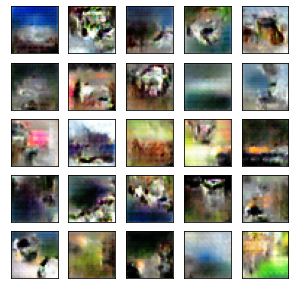

Epoch[66/100],d_loss:0.013694,g_loss:-0.025767 D real: 0.037771,D fake: 0.025767
Epoch[66/100],d_loss:-0.002420,g_loss:-0.047301 D real: 0.055002,D fake: 0.047301
Epoch[66/100],d_loss:-0.022289,g_loss:-0.008900 D real: 0.032717,D fake: 0.008900
Epoch[66/100],d_loss:-0.026825,g_loss:0.022205 D real: -0.002146,D fake: -0.022205


 67%|██████▋   | 67/100 [23:23<10:45, 19.57s/it]

Epoch[67/100],d_loss:0.012786,g_loss:-0.029837 D real: 0.022645,D fake: 0.029837
Epoch[67/100],d_loss:0.002666,g_loss:-0.056003 D real: 0.047481,D fake: 0.056003
Epoch[67/100],d_loss:-0.013713,g_loss:-0.026756 D real: 0.029106,D fake: 0.026756
Epoch[67/100],d_loss:-0.002038,g_loss:0.026507 D real: -0.002926,D fake: -0.026507


 68%|██████▊   | 68/100 [23:45<10:49, 20.29s/it]

Epoch[68/100],d_loss:-0.016499,g_loss:-0.039607 D real: 0.053839,D fake: 0.039607
Epoch[68/100],d_loss:-0.042599,g_loss:0.039065 D real: 0.003094,D fake: -0.039065
Epoch[68/100],d_loss:0.013710,g_loss:-0.019310 D real: 0.003054,D fake: 0.019310
Epoch[68/100],d_loss:-0.001711,g_loss:-0.024518 D real: 0.031027,D fake: 0.024518


 69%|██████▉   | 69/100 [24:07<10:38, 20.60s/it]

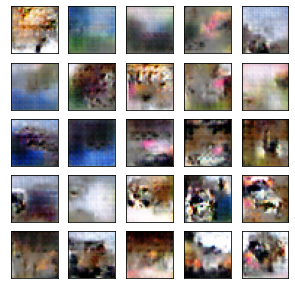

Epoch[69/100],d_loss:-0.002515,g_loss:-0.035919 D real: 0.048503,D fake: 0.035919
Epoch[69/100],d_loss:-0.009227,g_loss:-0.019989 D real: 0.053166,D fake: 0.019989
Epoch[69/100],d_loss:-0.014023,g_loss:0.046613 D real: -0.030934,D fake: -0.046613
Epoch[69/100],d_loss:-0.016833,g_loss:0.000584 D real: 0.052897,D fake: -0.000584


 70%|███████   | 70/100 [24:30<10:44, 21.47s/it]

Epoch[70/100],d_loss:-0.048994,g_loss:0.009651 D real: 0.040808,D fake: -0.009651
Epoch[70/100],d_loss:-0.046031,g_loss:-0.001655 D real: 0.028096,D fake: 0.001655
Epoch[70/100],d_loss:0.012405,g_loss:-0.087195 D real: 0.072512,D fake: 0.087195
Epoch[70/100],d_loss:-0.005516,g_loss:-0.009463 D real: 0.009934,D fake: 0.009463


 71%|███████   | 71/100 [24:53<10:34, 21.86s/it]

Epoch[71/100],d_loss:-0.042785,g_loss:0.043467 D real: 0.007800,D fake: -0.043467
Epoch[71/100],d_loss:-0.023294,g_loss:0.038681 D real: -0.013808,D fake: -0.038681
Epoch[71/100],d_loss:0.008554,g_loss:-0.008132 D real: -0.007640,D fake: 0.008132
Epoch[71/100],d_loss:-0.025487,g_loss:-0.026411 D real: 0.064254,D fake: 0.026411


 72%|███████▏  | 72/100 [25:12<09:47, 21.00s/it]

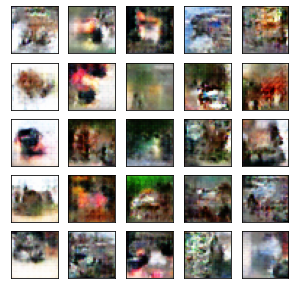

Epoch[72/100],d_loss:-0.053693,g_loss:0.010067 D real: 0.058885,D fake: -0.010067
Epoch[72/100],d_loss:-0.017752,g_loss:-0.036887 D real: 0.077316,D fake: 0.036887
Epoch[72/100],d_loss:-0.038968,g_loss:0.004011 D real: 0.058411,D fake: -0.004011
Epoch[72/100],d_loss:-0.015621,g_loss:0.051768 D real: 0.001748,D fake: -0.051768


 73%|███████▎  | 73/100 [25:35<09:45, 21.67s/it]

Epoch[73/100],d_loss:-0.009670,g_loss:-0.015740 D real: 0.010380,D fake: 0.015740
Epoch[73/100],d_loss:-0.020624,g_loss:0.021176 D real: 0.009663,D fake: -0.021176
Epoch[73/100],d_loss:-0.042103,g_loss:0.018554 D real: 0.042347,D fake: -0.018554
Epoch[73/100],d_loss:-0.038052,g_loss:-0.029968 D real: 0.031367,D fake: 0.029968


 74%|███████▍  | 74/100 [25:59<09:42, 22.40s/it]

Epoch[74/100],d_loss:-0.015128,g_loss:-0.009043 D real: 0.057337,D fake: 0.009043
Epoch[74/100],d_loss:-0.038995,g_loss:-0.030049 D real: 0.069447,D fake: 0.030049
Epoch[74/100],d_loss:-0.059137,g_loss:-0.014754 D real: 0.050823,D fake: 0.014754
Epoch[74/100],d_loss:-0.034305,g_loss:0.032148 D real: 0.028807,D fake: -0.032148


 75%|███████▌  | 75/100 [26:19<09:00, 21.64s/it]

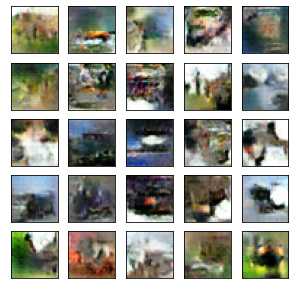

Epoch[75/100],d_loss:-0.015903,g_loss:0.006020 D real: 0.007447,D fake: -0.006020
Epoch[75/100],d_loss:-0.022394,g_loss:-0.036493 D real: 0.057842,D fake: 0.036493
Epoch[75/100],d_loss:-0.021862,g_loss:0.035140 D real: -0.007163,D fake: -0.035140
Epoch[75/100],d_loss:-0.033031,g_loss:-0.018712 D real: 0.077292,D fake: 0.018712


 76%|███████▌  | 76/100 [26:41<08:37, 21.55s/it]

Epoch[76/100],d_loss:-0.041418,g_loss:0.032140 D real: 0.022368,D fake: -0.032140
Epoch[76/100],d_loss:-0.008698,g_loss:-0.004523 D real: 0.001418,D fake: 0.004523
Epoch[76/100],d_loss:-0.018905,g_loss:0.025542 D real: 0.013090,D fake: -0.025542
Epoch[76/100],d_loss:0.005571,g_loss:-0.001925 D real: 0.028897,D fake: 0.001925


 77%|███████▋  | 77/100 [26:59<07:50, 20.47s/it]

Epoch[77/100],d_loss:-0.033575,g_loss:-0.009258 D real: 0.067608,D fake: 0.009258
Epoch[77/100],d_loss:-0.039615,g_loss:0.052926 D real: -0.008688,D fake: -0.052926
Epoch[77/100],d_loss:-0.006166,g_loss:-0.001695 D real: 0.016930,D fake: 0.001695
Epoch[77/100],d_loss:-0.026827,g_loss:0.005973 D real: 0.030789,D fake: -0.005973


 78%|███████▊  | 78/100 [27:15<07:02, 19.19s/it]

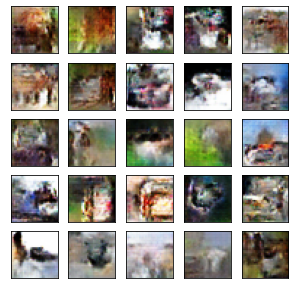

Epoch[78/100],d_loss:-0.020082,g_loss:-0.040212 D real: 0.052590,D fake: 0.040212
Epoch[78/100],d_loss:-0.021050,g_loss:-0.037623 D real: 0.069313,D fake: 0.037623
Epoch[78/100],d_loss:-0.042252,g_loss:0.024202 D real: 0.034655,D fake: -0.024202
Epoch[78/100],d_loss:-0.021041,g_loss:-0.016117 D real: 0.058315,D fake: 0.016117


 79%|███████▉  | 79/100 [27:40<07:21, 21.03s/it]

Epoch[79/100],d_loss:-0.013388,g_loss:0.016484 D real: 0.016904,D fake: -0.016484
Epoch[79/100],d_loss:-0.009549,g_loss:-0.053311 D real: 0.062328,D fake: 0.053311
Epoch[79/100],d_loss:-0.005053,g_loss:0.015945 D real: 0.041317,D fake: -0.015945
Epoch[79/100],d_loss:-0.027126,g_loss:-0.038718 D real: 0.037658,D fake: 0.038718


 80%|████████  | 80/100 [28:04<07:18, 21.93s/it]

Epoch[80/100],d_loss:-0.041977,g_loss:-0.027937 D real: 0.069162,D fake: 0.027937
Epoch[80/100],d_loss:-0.033562,g_loss:-0.002647 D real: 0.045427,D fake: 0.002647
Epoch[80/100],d_loss:-0.021196,g_loss:0.050446 D real: -0.011984,D fake: -0.050446
Epoch[80/100],d_loss:0.006504,g_loss:-0.013507 D real: 0.042142,D fake: 0.013507


 81%|████████  | 81/100 [28:24<06:47, 21.43s/it]

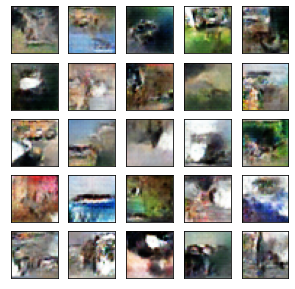

Epoch[81/100],d_loss:0.004460,g_loss:-0.079933 D real: 0.088001,D fake: 0.079933
Epoch[81/100],d_loss:-0.006158,g_loss:-0.035909 D real: 0.046106,D fake: 0.035909
Epoch[81/100],d_loss:0.007367,g_loss:-0.040086 D real: 0.055064,D fake: 0.040086
Epoch[81/100],d_loss:-0.044460,g_loss:-0.005104 D real: 0.059978,D fake: 0.005104


 82%|████████▏ | 82/100 [28:48<06:39, 22.21s/it]

Epoch[82/100],d_loss:0.005174,g_loss:-0.017623 D real: 0.051424,D fake: 0.017623
Epoch[82/100],d_loss:-0.015780,g_loss:0.001174 D real: 0.026581,D fake: -0.001174
Epoch[82/100],d_loss:-0.015312,g_loss:0.021072 D real: 0.018638,D fake: -0.021072
Epoch[82/100],d_loss:-0.024617,g_loss:-0.032777 D real: 0.042096,D fake: 0.032777


 83%|████████▎ | 83/100 [29:10<06:13, 21.96s/it]

Epoch[83/100],d_loss:-0.013222,g_loss:-0.009783 D real: 0.026873,D fake: 0.009783
Epoch[83/100],d_loss:-0.032134,g_loss:0.019489 D real: 0.040650,D fake: -0.019489
Epoch[83/100],d_loss:-0.003873,g_loss:0.026130 D real: -0.016002,D fake: -0.026130
Epoch[83/100],d_loss:-0.031052,g_loss:0.023893 D real: 0.031386,D fake: -0.023893


 84%|████████▍ | 84/100 [29:28<05:35, 20.97s/it]

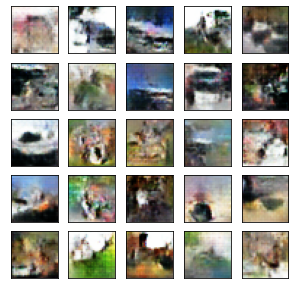

Epoch[84/100],d_loss:-0.022956,g_loss:-0.076111 D real: 0.104116,D fake: 0.076111
Epoch[84/100],d_loss:0.008138,g_loss:0.016302 D real: 0.011239,D fake: -0.016302
Epoch[84/100],d_loss:0.024401,g_loss:-0.033446 D real: 0.019162,D fake: 0.033446
Epoch[84/100],d_loss:-0.011410,g_loss:-0.017182 D real: 0.031504,D fake: 0.017182


 85%|████████▌ | 85/100 [29:51<05:23, 21.56s/it]

Epoch[85/100],d_loss:-0.037171,g_loss:-0.007482 D real: 0.043147,D fake: 0.007482
Epoch[85/100],d_loss:-0.006317,g_loss:0.002213 D real: 0.014873,D fake: -0.002213
Epoch[85/100],d_loss:-0.022559,g_loss:-0.012552 D real: 0.038473,D fake: 0.012552
Epoch[85/100],d_loss:-0.000470,g_loss:0.020932 D real: -0.000502,D fake: -0.020932


 86%|████████▌ | 86/100 [30:13<05:02, 21.62s/it]

Epoch[86/100],d_loss:0.010361,g_loss:-0.044484 D real: 0.026130,D fake: 0.044484
Epoch[86/100],d_loss:-0.004463,g_loss:-0.020688 D real: 0.022614,D fake: 0.020688
Epoch[86/100],d_loss:0.008449,g_loss:0.000879 D real: 0.006945,D fake: -0.000879
Epoch[86/100],d_loss:-0.011030,g_loss:-0.008294 D real: 0.028527,D fake: 0.008294


 87%|████████▋ | 87/100 [30:34<04:36, 21.30s/it]

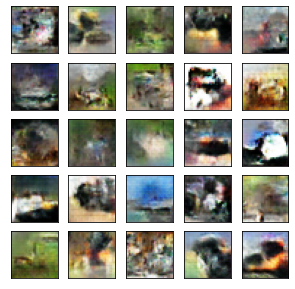

Epoch[87/100],d_loss:-0.011919,g_loss:-0.027430 D real: 0.040041,D fake: 0.027430
Epoch[87/100],d_loss:-0.014965,g_loss:-0.054736 D real: 0.040813,D fake: 0.054736
Epoch[87/100],d_loss:-0.019200,g_loss:-0.001376 D real: 0.021606,D fake: 0.001376
Epoch[87/100],d_loss:-0.001368,g_loss:-0.022282 D real: 0.032547,D fake: 0.022282


 88%|████████▊ | 88/100 [30:53<04:08, 20.69s/it]

Epoch[88/100],d_loss:-0.007242,g_loss:-0.011943 D real: 0.009293,D fake: 0.011943
Epoch[88/100],d_loss:-0.001182,g_loss:-0.029373 D real: 0.024691,D fake: 0.029373
Epoch[88/100],d_loss:-0.002794,g_loss:-0.018024 D real: 0.034422,D fake: 0.018024
Epoch[88/100],d_loss:-0.011559,g_loss:0.001004 D real: 0.026988,D fake: -0.001004


 89%|████████▉ | 89/100 [31:12<03:41, 20.10s/it]

Epoch[89/100],d_loss:0.006863,g_loss:0.002735 D real: -0.025275,D fake: -0.002735
Epoch[89/100],d_loss:-0.005369,g_loss:0.010092 D real: -0.001795,D fake: -0.010092
Epoch[89/100],d_loss:-0.018348,g_loss:-0.017792 D real: 0.037406,D fake: 0.017792
Epoch[89/100],d_loss:0.002133,g_loss:-0.002645 D real: 0.009983,D fake: 0.002645


 90%|█████████ | 90/100 [31:29<03:13, 19.37s/it]

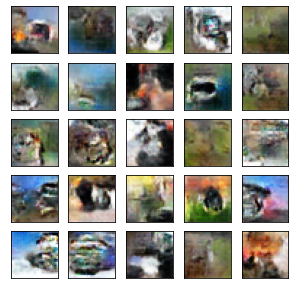

Epoch[90/100],d_loss:-0.009612,g_loss:-0.021605 D real: 0.032698,D fake: 0.021605
Epoch[90/100],d_loss:-0.002551,g_loss:-0.016972 D real: 0.020926,D fake: 0.016972
Epoch[90/100],d_loss:-0.014430,g_loss:-0.002928 D real: 0.017912,D fake: 0.002928
Epoch[90/100],d_loss:-0.005940,g_loss:-0.041394 D real: 0.055677,D fake: 0.041394


 91%|█████████ | 91/100 [31:53<03:06, 20.75s/it]

Epoch[91/100],d_loss:0.002796,g_loss:-0.015086 D real: 0.018713,D fake: 0.015086
Epoch[91/100],d_loss:-0.001472,g_loss:-0.024488 D real: 0.026113,D fake: 0.024488
Epoch[91/100],d_loss:0.004271,g_loss:-0.021460 D real: 0.019868,D fake: 0.021460
Epoch[91/100],d_loss:-0.003751,g_loss:-0.021147 D real: 0.024179,D fake: 0.021147


 92%|█████████▏| 92/100 [32:15<02:48, 21.05s/it]

Epoch[92/100],d_loss:0.009485,g_loss:-0.012809 D real: -0.001188,D fake: 0.012809
Epoch[92/100],d_loss:-0.001548,g_loss:-0.004379 D real: 0.006790,D fake: 0.004379
Epoch[92/100],d_loss:-0.008716,g_loss:-0.011993 D real: 0.020005,D fake: 0.011993
Epoch[92/100],d_loss:-0.000490,g_loss:0.017650 D real: -0.020312,D fake: -0.017650


 93%|█████████▎| 93/100 [32:30<02:14, 19.22s/it]

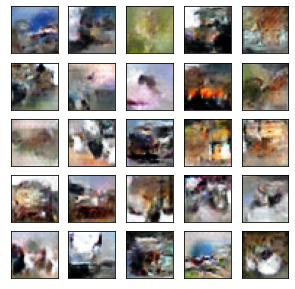

Epoch[93/100],d_loss:-0.005841,g_loss:0.010026 D real: -0.011498,D fake: -0.010026
Epoch[93/100],d_loss:-0.001312,g_loss:0.010542 D real: -0.005208,D fake: -0.010542
Epoch[93/100],d_loss:0.001292,g_loss:-0.014115 D real: 0.015675,D fake: 0.014115
Epoch[93/100],d_loss:0.001596,g_loss:0.000306 D real: -0.004920,D fake: -0.000306


 94%|█████████▍| 94/100 [32:53<02:02, 20.36s/it]

Epoch[94/100],d_loss:-0.000071,g_loss:-0.006250 D real: 0.008780,D fake: 0.006250
Epoch[94/100],d_loss:-0.011942,g_loss:-0.017602 D real: 0.026114,D fake: 0.017602
Epoch[94/100],d_loss:0.006872,g_loss:-0.040944 D real: 0.038543,D fake: 0.040944
Epoch[94/100],d_loss:0.009358,g_loss:-0.036326 D real: 0.046939,D fake: 0.036326


 95%|█████████▌| 95/100 [33:11<01:38, 19.67s/it]

Epoch[95/100],d_loss:-0.016854,g_loss:-0.032697 D real: 0.042211,D fake: 0.032697
Epoch[95/100],d_loss:0.011034,g_loss:-0.075875 D real: 0.065392,D fake: 0.075875
Epoch[95/100],d_loss:-0.002510,g_loss:-0.058394 D real: 0.039910,D fake: 0.058394
Epoch[95/100],d_loss:-0.001253,g_loss:-0.061096 D real: 0.066370,D fake: 0.061096


 96%|█████████▌| 96/100 [33:35<01:23, 20.91s/it]

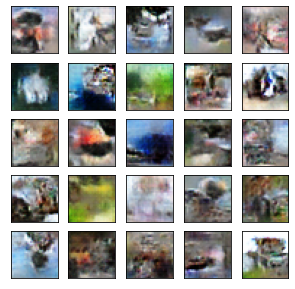

Epoch[96/100],d_loss:0.007260,g_loss:0.007911 D real: 0.006473,D fake: -0.007911
Epoch[96/100],d_loss:-0.008392,g_loss:0.035903 D real: -0.023574,D fake: -0.035903
Epoch[96/100],d_loss:-0.004068,g_loss:-0.001470 D real: 0.010536,D fake: 0.001470
Epoch[96/100],d_loss:0.002529,g_loss:-0.068588 D real: 0.059688,D fake: 0.068588


 97%|█████████▋| 97/100 [33:58<01:04, 21.61s/it]

Epoch[97/100],d_loss:-0.005523,g_loss:-0.024545 D real: 0.035965,D fake: 0.024545
Epoch[97/100],d_loss:0.009023,g_loss:-0.003755 D real: -0.001909,D fake: 0.003755
Epoch[97/100],d_loss:0.000722,g_loss:-0.061751 D real: 0.053988,D fake: 0.061751
Epoch[97/100],d_loss:0.012513,g_loss:-0.041017 D real: 0.018009,D fake: 0.041017


 98%|█████████▊| 98/100 [34:23<00:45, 22.59s/it]

Epoch[98/100],d_loss:0.002629,g_loss:0.023676 D real: -0.021238,D fake: -0.023676
Epoch[98/100],d_loss:-0.019038,g_loss:0.004738 D real: 0.013192,D fake: -0.004738
Epoch[98/100],d_loss:-0.001601,g_loss:0.032038 D real: -0.014189,D fake: -0.032038
Epoch[98/100],d_loss:-0.002955,g_loss:-0.005729 D real: 0.022788,D fake: 0.005729


 99%|█████████▉| 99/100 [34:42<00:21, 21.41s/it]

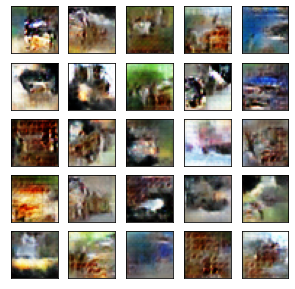

Epoch[99/100],d_loss:-0.008852,g_loss:0.043923 D real: -0.036748,D fake: -0.043923
Epoch[99/100],d_loss:-0.003531,g_loss:-0.033651 D real: 0.030789,D fake: 0.033651
Epoch[99/100],d_loss:-0.007028,g_loss:0.002278 D real: 0.003146,D fake: -0.002278
Epoch[99/100],d_loss:-0.010004,g_loss:0.036588 D real: -0.031309,D fake: -0.036588


100%|██████████| 100/100 [35:07<00:00, 21.07s/it]


"    if epoch == 0:\n        real_images = inv_normalize(real_img.cpu().data)\n        save_image(real_images, '../../img/real_images.png')\n \n    fake_images = inv_normalize(fake_img.cpu().data)\n    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))"

In [10]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epoch)):
    if epoch % 3 == 0:
        G.eval()
        z = torch.randn(25, z_dim,1,1).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow((inv_normalize(img[k]) * 255).data.cpu().numpy().transpose((1,2,0)).astype(np.uint8))
            k += 1
        plt.show()
        
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images


        # ========================= D: Forward and Loss ==========================
        # D_loss: wasserstein loss for discriminator, -E[D(x)] + E[D(G(z))]        
        real_out = D(real_img).view(-1,1)
        
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        d_loss = -1 * torch.mean(real_out) + torch.mean(fake_out)
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        D.clip_weights(clip)
        D_losses.append(d_loss)
        # =============== G ========================
        #G_loss: wasserstein loss for generator, -E[D(G(z))]
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        g_loss = -1 * (torch.mean(fake_out))
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss)
        # ============= Visualization ===============
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
'''    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))'''

# Visualization

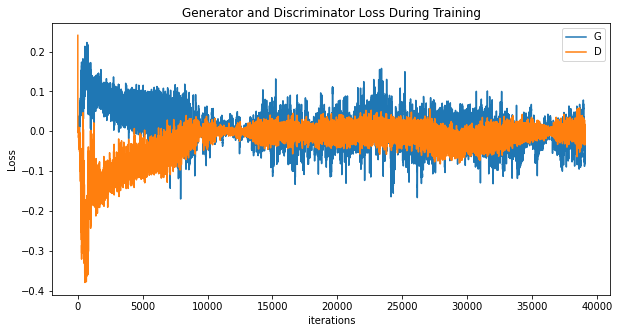

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Debug 专区